In [1]:
%pylab inline
from IPython.display import Audio
import librosa
import scipy as sp
from numba import jit
from scipy.spatial import distance

figsize(20,6)
prefix="baseline"
def filepre(nm):
    return "tmp/"+prefix+"_"+nm
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload
%autoreload 1

%aimport microbial

In [3]:

def nrmse(output,target):
    assert(output.shape[0] == target.shape[0])
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = max(abs(np.linalg.eig(internalWeights)[0]))
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights

pLoop = lambda n,p: p[n%p.size]

In [4]:
from datetime import datetime
import os
resultsFolderName = "fbsynthResults/csoc_results" + str(datetime.now()) + "/"
os.mkdir(resultsFolderName)


In [5]:
# relevant_path = "audios/ixi"
# ixiFiles = [fn for fn in os.listdir(relevant_path)
#               if fn.endswith('wav')]
# ixiFiles = ['909a_22k.wav']
ixiFiles = ['397428__cabled-mess__doepfer-a-110-1-vco-rectangle-c2-8k.wav']
print(ixiFiles)


['397428__cabled-mess__doepfer-a-110-1-vco-rectangle-c2-8k.wav']


In [6]:
def ixistr(id):
    return str(id) + "_" + ixiFiles[id] + "_"

In [7]:
def compareMFCCs(seq1, seq2):
    fftSize=2048
    hop=1024  
    melspec = librosa.feature.melspectrogram(y=seq1, sr=sr, n_fft=fftSize,hop_length=hop)
    mfccs = librosa.feature.mfcc(S=melspec,n_mfcc=20)[1:,:]
    melspec2 = librosa.feature.melspectrogram(y=seq2, sr=sr, n_fft=fftSize,hop_length=hop)
    mfccs2 = librosa.feature.mfcc(S=melspec2,n_mfcc=20)[1:,:]    
    return nrmse(mfccs.flatten(), mfccs2.flatten())

def compareMelSpec(seq1, seq2):
    fftSize=2048
    hop=1024  
    melspec = librosa.feature.melspectrogram(y=seq1, sr=sr, n_fft=fftSize,hop_length=hop)
    melspec2 = librosa.feature.melspectrogram(y=seq2, sr=sr, n_fft=fftSize,hop_length=hop)
    return nrmse(melspec.flatten(), melspec2.flatten())
        

def evoEvalFeedbackModel(patterns, patternLengths, N, lr, biasScale, inScale, plotResult=False):
    print("Eval model, args: ", N, lr)
    W = generateInternalWeights(N, 10.0/N)
    Win = (np.random.rand(N, 1) - 0.5) * 2 * inScale
    Wbias = (np.random.rand(N, 1) - 0.5) * biasScale
    x = (np.random.rand(N, 1) - 0.5) 
    orgX = x.copy()
    firstPattern=0
    lastPattern = patterns.shape[0]
    sequences = patterns[firstPattern:lastPattern]
    # sequence1 = [patterns[startPattern+0].take(x, mode='wrap') for x in range(seqLen)] #pow(sin(arange(seqLen)/4),1) * 0.5
    learnLen = 4
    trainLen = sum(patternLengths[firstPattern:lastPattern])
#     washoutLen= patterns[0].shape[0]*4
    washoutLen= 20


    loadingTrials = 1
    loadingTrialResults = zeros(loadingTrials)
    bestLoadingError=999
    bestW = W.copy()
    bestWin = Win.copy()
    bestWbias = Wbias.copy()
    allTrain = zeros(trainLen)
    
    for loadingTrial in range(loadingTrials):
        W = generateInternalWeights(N, 10.0/N) * 0.2
        Win = (np.random.rand(N, 1) - 0.5) * 2
        Wbias = (np.random.rand(N, 1) - 0.5) * 0.1
        #run to washout
        for n in range(washoutLen):
            xOld = x
            Wtarget = (W.dot(x)) + (Win.dot(sequences[0].take(n, mode='wrap')))
            newX =lr * tanh(Wtarget + Wbias)
            oldX = (1 - lr) * xOld
            x = newX + oldX 

        #observe to adjust W - load patterns into the network
        xOldCollector = np.zeros((N, trainLen));    
        WTargetCollector = np.zeros((N, trainLen)); 
        trainIdx = 0
        for seq in range(sequences.shape[0]):
            for n in range(patternLengths[firstPattern + seq]):
                xOld = x
                u = sequences[seq][n]
                Wtarget = (W.dot(x)) + (Win.dot(u))
                newX =lr * tanh(Wtarget + Wbias)
                oldX = (1 - lr) * xOld
                x = newX + oldX 

                xOldCollector[:, trainIdx] = xOld[:,0]
                WTargetCollector[:, trainIdx] = Wtarget[:,0]
                allTrain[trainIdx] = u
#             trainIdx = trainIdx+1
                trainIdx = trainIdx + 1


        W = (linalg.inv(xOldCollector.dot(xOldCollector.T) +
                          (1e-4 * np.eye(N))).dot(xOldCollector).dot(WTargetCollector.T)).T

        NRMSE_W = mean(nrmse(W.dot(xOldCollector), WTargetCollector))
#         absSize_W = mean(mean(abs(W), axis=0))
#         print("W error: ", NRMSE_W, absSize_W)
        loadingTrialResults[loadingTrial] = NRMSE_W
        if (NRMSE_W < bestLoadingError):
            bestLoadingError = NRMSE_W
            bestW = W.copy()
            bestWin = Win.copy()
            bestWbias = Wbias.copy()


    W = bestW.copy()
    Win = bestWin.copy()
    Wbias = bestWbias.copy()

#     print("Mean loading error: ", mean(loadingTrialResults))


    Wouts = np.zeros((sequences.shape[0], N+1)); 
    cues = np.zeros((N,sequences.shape[0])); 

    # x = orgX.copy()
    x = 0.5 * np.random.randn(N,1)


    #run to washout
    for n in range(washoutLen):
        xOld = x
        Wtarget = (W.dot(x)) + (Win.dot(sequences[0].take(n, mode='wrap')))
        newX =lr * tanh(Wtarget + Wbias )
        oldX = (1 - lr) * xOld
        x = newX + oldX 


    trainIdx = 0
#     readOutErrors = zeros(sequences.shape[0])
#     readOutErrorsMel = zeros(sequences.shape[0])
    for seq in range(sequences.shape[0]):
        seqLen = sequences[seq].shape[0] * learnLen
        xCollector = np.zeros((N + 1, seqLen-1));    
        pCollector = np.zeros((1, seqLen-1));  
        for n in range(seqLen-1):
            xOld = x
            u = sequences[seq][n % sequences[seq].shape[0]]
            Wtarget = (W.dot(x)) + (Win.dot(u))
            newX =lr * tanh(Wtarget + Wbias )
            oldX = (1 - lr) * xOld
            x = newX + oldX 

            xCollector[:, n] = np.concatenate((x[:,0], np.array([1])))
            pCollector[0, n] = sequences[seq][(n+1) % sequences[seq].shape[0]]
#             allTrain[trainIdx] = u
#             trainIdx = trainIdx+1

        Wouts[seq] = hstack(linalg.inv(xCollector.dot(xCollector.T) + (1e-4 * np.eye(N + 1))).dot(xCollector).dot(pCollector.T))
        cues[:, seq] = x[:,0]

#         outsRecovered = Wouts[seq].dot(xCollector);
#         NRMSE_readout = mean(nrmse(outsRecovered, pCollector[0,:]))
#         absSize_readout = mean(mean(abs(Wouts[seq]), axis=0))
#         print("Wout error " + str(seq) + ": ", NRMSE_readout, absSize_readout)

#         readOutErrorsMel[seq] = compareMFCCs(outsRecovered, pCollector[0,:])
#         print("Wout mel error " + str(seq) + ": ", readOutErrorsMel[seq])

#         readOutErrors[seq] = NRMSE_readout

#     meanReadoutError = mean(readOutErrors)
#     meanMelReadoutError = mean(readOutErrorsMel)
#     print("Mean readout error: ", meanReadoutError, ", mean mel readout error: ", meanMelReadoutError)




    results = zeros(sequences.shape[0])

#     for cueIdx in range(sequences.shape[0]):
# #             print("Cue: ", cueIdx)
#         runLen = sequences[cueIdx].shape[0] * 4
#         outCollector = np.zeros((1, runLen));  

#         x = cues[:,[cueIdx]]

#         for n in range(runLen):  
#             xOld = x
#             Wtarget = (W.dot(x)) + (Win.dot(u))
#             newX =lr * tanh(Wtarget + Wbias)
#             oldX = (1 - lr) * xOld
#             x = newX + oldX 
#             u = Wouts[cueIdx].dot(np.concatenate((x[:,0], np.array([1]))))
#             outCollector[0, n] = u

#         targetPattern = array([sequences[cueIdx].take(x,mode='wrap') for x in range(runLen)])
#         templateScan = np.correlate(outCollector[0][:sequences[cueIdx].shape[0]*2],sequences[cueIdx])
#         matchPoint = np.argmax(templateScan)
#         outputPattern = outCollector[0]
#         if (matchPoint > 0):
#             outputPattern = outputPattern[matchPoint:]
#             targetPattern = targetPattern[:-matchPoint]
#         evalLen = sequences[cueIdx].shape[0] * 2

#         results[cueIdx] = compareMFCCs(outputPattern[-evalLen:], targetPattern[-evalLen:])
#         if plotResult:
#             figsize(20,60)
#             ax = subplot(sequences.shape[0], 1, cueIdx+1)
#             ax.set_title("Sequence " + str(cueIdx) + ", NRMSE: " + str(results[cueIdx]))    
#             plot(outputPattern)
#             plot(targetPattern)
#             print("NRMSE: ", results[cueIdx])

#     meanRes = median(results)
#     print("Median error: ", meanRes)
    cueSequence = zeros((sequences.shape[0],2), dtype=int)
    for i in range(sequences.shape[0]-1):
        cueSequence[i+1][0] = sequences[i].shape[0] + cueSequence[i][0]
        cueSequence[i+1][1] = i+1
#     return {"res":meanRes, "model":{'W':W, 'Win':Win, 'Wbias':Wbias, 'Wouts':Wouts, 
#                                     'cueSequence':cueSequence, 'N':N, 'lr':lr,
#                                     'trainingSeq':allTrain}}
    return {"model":{'W':W, 'Win':Win, 'Wbias':Wbias, 'Wouts':Wouts, 
                                    'cueSequence':cueSequence, 'N':N, 'lr':lr,
                                    'trainingSeq':allTrain}}

def evoEvalFeedbackSynthesis(model, plotResult=False, lrMod=1, cue=None, srMod=1, lenMult=1):
#     print("Resynthesis, lr: ", model['lr'] * lrMod)
    runLen = model['trainingSeq'].shape[0] * lenMult
#     print("Runlen: ",runLen)
    u = 0
    x=None
    if (cue is None):
        x = 0.5 * np.random.randn(model['N'],1)
    else:
        x = cue
    cue = x.copy()
    LR = model['lr'] * lrMod
    Wmod = model['W'] * srMod
    #run to washout
    for n in range(model['trainingSeq'].shape[0]):
        xOld = x
        Wtarget = (Wmod.dot(x)) + (model['Win'].dot(u))
        newX =LR * tanh(Wtarget + model['Wbias'])
        oldX = (1 - LR) * xOld
        x = newX + oldX 
        u = model['Wouts'][0].dot(np.concatenate((x[:,0], np.array([1]))))

    outCollector = np.zeros((1, runLen));  
    cueSequence = model['cueSequence'].copy()
    cueIdx=0
    nextCue = cueSequence[0]
    for n in range(runLen):
        if (n == nextCue[0]):
            cueIdx = nextCue[1]
    #         x = cues[:,cueIdx]
    #         u = sequences[cueIdx][0]
            if (cueSequence.shape[0] > 1):
                cueSequence = cueSequence[1:]
                nextCue = cueSequence[0]
#                 print(cueIdx, end="'")

        xOld = x
        Wtarget = (Wmod.dot(x)) + (model['Win'].dot(u))
        newX =LR * tanh(Wtarget + model['Wbias'])
        oldX = (1 - LR) * xOld
        x = newX + oldX 
        u = model['Wouts'][cueIdx].dot(np.concatenate((x[:,0], np.array([1]))))
        outCollector[0, n] = u
#         print (model['trainingSeq'].shape, outCollector.shape)
#     error = compareMFCCs(outCollector[0], model['trainingSeq'])
    error = compareMelSpec(outCollector[0], np.tile(model['trainingSeq'], lenMult))
#     print("Error: ", error)

    if (plotResult):
        print("Plotting results")
        figsize(20,3)
        figure(1)
        plot(model['trainingSeq'])
        plot(outCollector[0])
        figure(2)
        plot(outCollector[0])
    return {"error":error, "waveform":outCollector[0], "cue":cue}

In [8]:




def evalModel(params, patterns, patternLengths, modelcount, synthcount):
    bestScore=99999
    bestModel={}
    bestResult = {}
    
    for i in range(modelcount):
        modelEvalResult = evoEvalFeedbackModel(patterns, patternLengths, int(20 + (params[0] * 780)), params[1], params[2], params[3] * 1)
        for j in range(synthcount):
            synthesisResult = evoEvalFeedbackSynthesis(modelEvalResult["model"], False)
            score = synthesisResult["error"]
            print(score, end=',')
            if score < bestScore:
                bestResult = synthesisResult
                bestScore = score
                bestModel = modelEvalResult["model"]
                print("@@")
        print("")
    return {"bestModel":bestModel, "bestScore": bestScore, "bestResult":bestResult}
                
def evalFitness(params, data):

    bestModelData = evalModel(params, data['patterns'], data['patternLengths'], 10, 10)
    if ("winner" in data):
        if bestModelData['bestScore'] < data['winner']['bestScore']:
            data['winner'] = bestModelData
    else:
        data['winner'] = bestModelData
    return bestModelData["bestScore"]




(123,) 8000


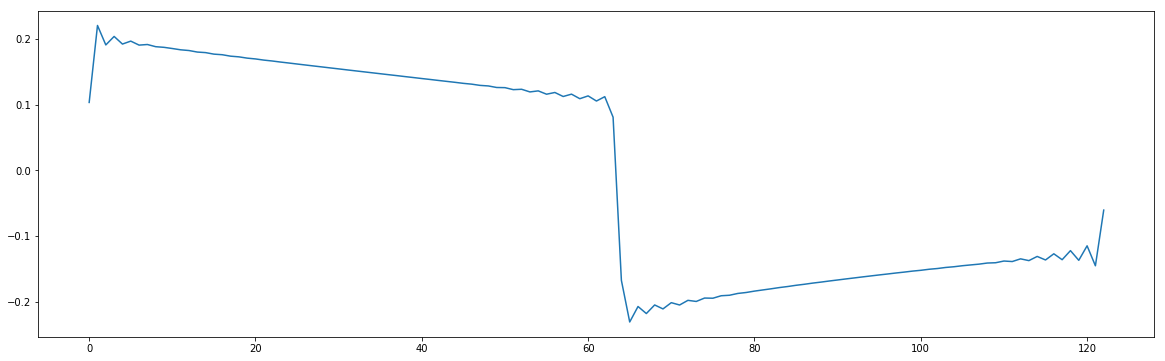

In [9]:
y, sr = librosa.load("audios/397428__cabled-mess__doepfer-a-110-1-vco-rectangle-c2-8k.wav", sr=8000)
y = y[0:123]
windowSize = len(y)
# nWindows = 1
print(y.shape,  sr)
patterns = np.zeros(1, dtype=np.object)
patterns[0] = np.array(y,dtype=float64)
plot(patterns[0])


0:09:40.081169
Runtime: None
0 / 1  :  397428__cabled-mess__doepfer-a-110-1-vco-rectangle-c2-8k.wav
=============== epoch  49
Scores:  [0.1322997  0.27821915 0.67977436 0.48865613 1.24701156 0.06508988
 0.12006257 0.09602314]  best:  0.06508988016555727 5  mean:  0.38839205990381365
[[0.07275006 0.         0.21402973 0.65718734]
 [0.94024025 0.06495636 0.11082064 0.13077049]
 [0.35813855 0.25282773 0.5965266  0.52853733]
 [0.33358048 0.21387433 0.59037201 0.51366298]
 [0.98044152 0.21387433 0.4362907  0.58850645]
 [0.05115402 0.06274969 0.21402973 0.71145857]
 [0.48337692 0.03753876 0.19323453 0.70901874]
 [0.05115402 0.10395667 0.21402973 0.71145857]]

fight:  [5 3] ,  0
CPU times: user 12min 29s, sys: 1min 44s, total: 14min 14s
Wall time: 9min 40s


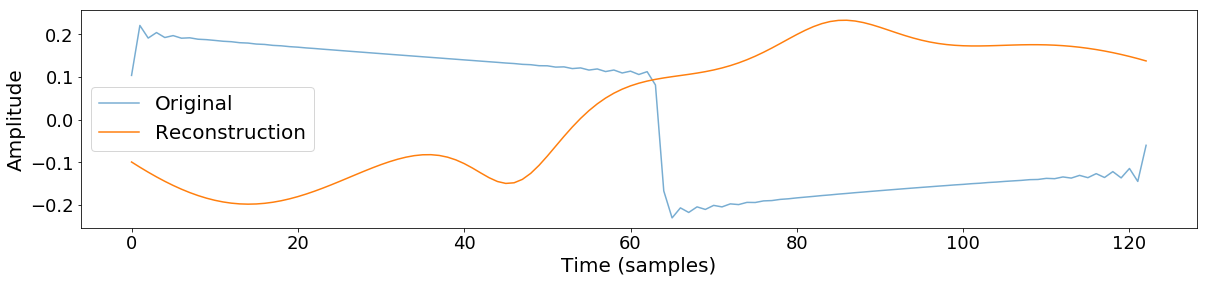

In [13]:
%%time
startTS = datetime.now()
for currentIxi in range(len(ixiFiles)):
    clear_output()
#     print("loading: ", ixiFiles[currentIxi])
#     y, sr = librosa.load("audios/ixi/" + ixiFiles[currentIxi], sr=8000)
#     y = y[:5000] / np.max(y) * 0.5
#     print(sr)

    #divide out windows
#     patterns = []

#     minPatternSize = 9
#     lastCrossing=0
#     for i in range(y.shape[0]-1):
#         if (i-lastCrossing) > minPatternSize and y[i] >=0 and y[i+1] < 0:
#             print(i)
#             segment = y[lastCrossing:i]
#             patterns.append(segment)
#             lastCrossing = i
            
    #convert to numpy
#     patterns = np.array(patterns, dtype=np.object)
#     maxPatterns = 150
#     patterns = patterns[:maxPatterns]
    patternLengths = [x.shape[0] for x in patterns]
    y = y[:sum(patternLengths)]
    maxPatternLen = np.max(patternLengths)
    minPatternLen = np.min(patternLengths)
    print("max length: ", maxPatternLen)
    print("min length: ", minPatternLen)
    # for p in patterns:
    #     plot(p)
    print(patterns.shape)
    
    pop = microbial.createPop(8, 4, 99999) 
    
    data = {'patterns':patterns, 'patternLengths':patternLengths}
    def onEpochStart():
        clear_output()
        print('Runtime:', print(datetime.now() - startTS))
        print(currentIxi, '/', len(ixiFiles), ' : ', ixiFiles[currentIxi])
        f = open(resultsFolderName + ixistr(currentIxi) + "evoLog.txt", "a")
        f.write(str(pop))
        f.close()

    microbial.evolve(pop, evalFitness, microbial.criterionMin, data, 4, 50, 0.2, 0.5, 0.5 , onEpochStart)
    
    plt.close()
    figsize(20,4)
    plt.xlabel("Time (samples)", fontsize=20)
    plt.ylabel("Amplitude", fontsize=20)
    plt.xticks(fontsize=18, rotation=0)
    plt.yticks(fontsize=18, rotation=0) 
    plot(y[:data['winner']['bestResult']['waveform'].shape[0]], label='Original', alpha=0.6)
    plot(data['winner']['bestResult']['waveform'], alpha=1.0, label='Reconstruction')
    plt.legend(fontsize=20)
    plt.savefig(resultsFolderName + ixistr(currentIxi) + "compare.pdf", bbox_inches='tight')

    librosa.output.write_wav(resultsFolderName + ixistr(currentIxi) + "org.wav",y, sr)
    librosa.output.write_wav(resultsFolderName + ixistr(currentIxi) + "recon.wav", data['winner']['bestResult']['waveform'], sr)

    import dill as pickle
    with open(resultsFolderName + ixistr(currentIxi) + r"model.dill.pickled", "wb") as output_file:    
        pickle.dump({'winner':data['winner'], 'pop':pop, 'original':y, 'patterns':patterns}, output_file, protocol=0)


In [14]:
compareMelSpec(y, data['winner']["bestResult"]['waveform'])

0.06508988016555727

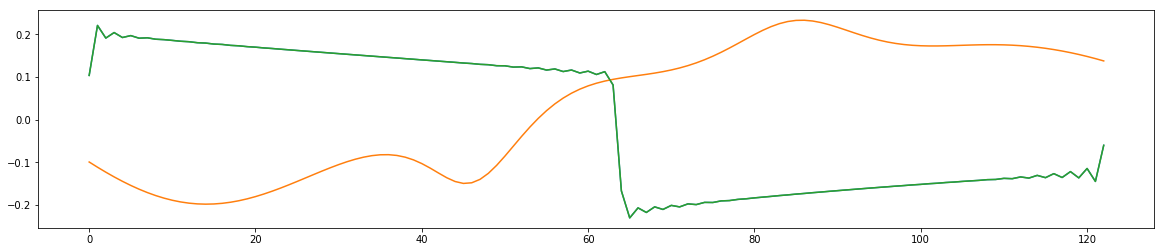

In [15]:
plot(y)
plot(data['winner']["bestResult"]['waveform'])
plot(data['winner']['bestModel']['trainingSeq'])


In [19]:
y.shape

(5000,)

In [13]:
sum(patternLengths)

4857

In [ ]:
%%time
model = evalModel(pop["genes"][pop["bestIdx"]], 20, 20)

In [ ]:
model

Plotting results


{'cue': array([[-0.06038593],
        [-0.81721827],
        [ 1.36324977],
        [-0.15783947],
        [ 0.2143525 ],
        [ 0.25763746],
        [ 0.73482215],
        [-0.05020737],
        [-0.54784276],
        [ 0.09223727],
        [-0.0180244 ],
        [ 0.43179857],
        [ 0.53059435],
        [ 0.20609656],
        [-0.06211418],
        [ 0.2233386 ],
        [ 0.00293581],
        [-0.57259916],
        [ 0.16376869],
        [ 0.08119682],
        [ 0.36429625],
        [-0.71131665],
        [-0.07489919],
        [-0.12039976],
        [ 0.14834127],
        [-0.25457426],
        [ 0.26134994],
        [-0.05631018],
        [ 1.22387746],
        [-0.657901  ],
        [ 0.48645893],
        [ 0.12079625],
        [-0.54343315],
        [ 0.1948249 ],
        [ 0.37222174],
        [-0.34883959],
        [-0.4703278 ],
        [ 0.298353  ],
        [-0.60163417],
        [-0.1642181 ]]),
 'error': 0.07228579116082379,
 'waveform': array([ 0.0933751 ,  0.1152

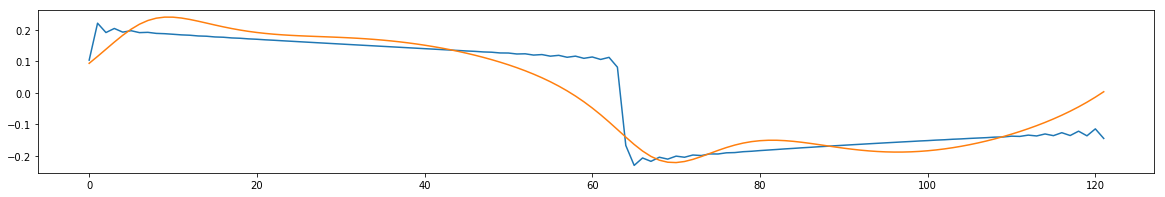

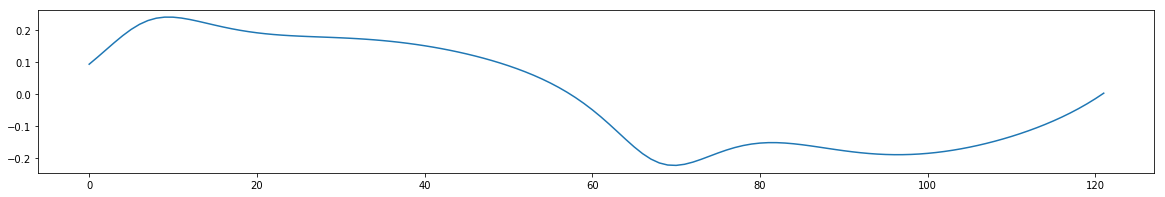

In [123]:
evoEvalFeedbackSynthesis(data['winner']["bestModel"], True, lrMod=1, cue=data['winner']["bestResult"]['cue'], srMod=1, lenMult=1)

In [16]:
librosa.output.write_wav("tmp/osc_rect_fb_recon.wav", data['winner']['bestResult']['waveform'], sr)


In [103]:
Audio(data=data['winner']['bestResult']['waveform'],rate=sr)

In [ ]:
sr

In [ ]:
Audio(data=model['bestResult']['waveform'],rate=sr)